In [150]:
import json
import pandas as pd
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client['local']
col = db['cleaned_data']
source_sub = []

features = []

#class PacketDataa:

# denestes the pure pcap json objects to single object
def flatten_data(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out


# reads in the raw json captures and formats them into 
# workble objects then pushes them into a new cleaned database
with open("local.traffic_capture_2.json", 'r') as f:
    data = json.load(f)
    print(len(data))
    for j in range(len(data)):
        jsonobj = json.loads(json.dumps(data[j]))
        packetjson = json.loads(jsonobj["pcap"])
        
        for packet in range(len(packetjson)):
            subobj = json.loads(json.dumps(packetjson[packet]['_source']))
            flatobj = {
                "label" : jsonobj["event_type"]
            }
            flatobj.update(flatten_data(subobj))
            for keys in flatobj.keys():
                if keys not in features:
                    features.append(keys)
            #col.insert_one(flatobj)


266


In [165]:
import pymongoarrow.api as pymongoarrow
from pandas import json_normalize

# get the data from the cleaned mongodb collection
cursor = col.find()
list_data = list(cursor)
df = json_normalize(list_data)
df = df.drop('_id', axis=1)

#selected features
working_features = [
    'layers_frame_frame.time_delta',
    'layers_frame_frame.time_relative',
    'layers_frame_frame.len',
    'layers_frame_frame.cap_len',
    'layers_eth_eth.dst_tree_eth.dst.oui',
    'layers_eth_eth.src_tree_eth.src.oui',
    'layers_eth_eth.src_tree_eth.addr.oui',
    'layers_ip_ip.hdr_len',
    'layers_ip_ip.len',
    'layers_ip_ip.ttl',
    'layers_ip_ip.checksum.status',
    'layers_ip_ip.src',
    'layers_ip_ip.addr',
    'layers_ip_ip.src_host',
    'layers_ip_ip.host',
    'layers_ip_ip.dst',
    'layers_ip_ip.dst_host',
    'layers_tcp_tcp.srcport',
    'layers_tcp_tcp.dstport',
    'layers_tcp_tcp.port',
    'layers_tcp_tcp.len',
    'layers_tcp_tcp.seq_raw',
    'layers_tcp_tcp.hdr_len',
    'layers_tcp_tcp.window_size_value',
    'layers_tcp_tcp.analysis_tcp.analysis.bytes_in_flight',
    'layers_tcp_tcp.analysis_tcp.analysis.push_bytes_sent',
    'layers_tls_tls.record_tls.record.content_type',
    'layers_tls_tls.record_tls.record.length'
]

# features that are not encodable 
unencoded_features = ['layers_frame_frame.interface_id_tree_frame.interface_name', 
                'layers_frame_frame.time',
               'layers_frame_frame.time_utc',
               'layers_frame_frame.protocols',
               'layers_eth_eth.dst',
               'layers_eth_eth.dst_tree_eth.addr',
               'layers_eth_eth.src',
               'layers_eth_eth.dst_tree_eth.dst_resolved',
               'layers_eth_eth.dst_tree_eth.dst.oui_resolved',
               'layers_eth_eth.dst_tree_eth.addr_resolved',
               'layers_eth_eth.dst_tree_eth.addr.oui_resolved',
               'layers_eth_eth.src_tree_eth.src_resolved',
                'layers_eth_eth.src_tree_eth.addr',
                'layers_eth_eth.src_tree_eth.addr_resolved',
                'layers_eth_eth.type',
                'layers_ip_ip.dsfield',
                'layers_arp_arp.proto.type',
                'layers_arp_arp.src.hw_mac',
                'layers_arp_arp.dst.hw_mac',
                'layers_eth_eth.src_tree_eth.src.oui_resolved',
                'layers_eth_eth.src_tree_eth.addr_resolved',
                'layers_eth_eth.src_tree_eth.addr.oui_resolved',
                'layers_ip_ip.id',
                'layers_ip_ip.flags',
                'layers_ip_ip.checksum',
                'layers_tcp_tcp.completeness_tree_tcp.completeness.str',
                'layers_tcp_tcp.flags',
                'layers_tcp_tcp.flags_tree_tcp.flags.str',
                'layers_tcp_tcp.checksum',
                'layers_tcp_tcp.payload',
                'layers_tls_tls.record_tls.app_data',
                'layers_tls_tls.record_tls.record.version',
                'layers_tcp_tcp.segment_data'
               ]

# features we can encode by removing the '.''s
ipaddr = [
    'layers_arp_arp.src.proto_ipv4',
    'layers_arp_arp.dst.proto_ipv4',
    'layers_ip_ip.src',
    'layers_ip_ip.addr',
    'layers_ip_ip.src_host',
    'layers_ip_ip.host',
    'layers_ip_ip.dst',
    'layers_ip_ip.dst_host'
]

# clean the ipv4 addresses
for ipadd in ipaddr:
    df[ipadd] = df[ipadd].str.replace(r'.', '')

# split of the labels and create the working feature dataframe
labels = df['label']
print(labels.value_counts())
features = df.drop('label', axis=1)
workingdf = features[working_features]



label
live_view    1960
idle         1880
motion       1480
Name: count, dtype: int64


In [166]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

print(labels.describe())
#split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(workingdf, labels, test_size=0.3)

feature_names = [ f'{workingdf.columns[i]}' for i in range(workingdf.shape[1])]

clf = tree.DecisionTreeClassifier()

# initialize the dataframes that will hold the results of each split and fit

performance_df = pd.DataFrame(columns=['Run', 'Accuracy', '1st', '2nd', '3rd', '4th', '5th'])
importances = pd.DataFrame(columns=['feature', 'importance'])

# collect 100 split and fit runs

for i in range(0,100):

    X_train, X_test, y_train, y_test = train_test_split(workingdf, labels, test_size=0.3)
    
    clf = clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)

    
    high_information = clf.feature_importances_
    
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': high_information})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    performance_df.loc[i] = [ i, accuracy_score(y_test, y_hat), [feature_importance_df.iloc[0]['feature'], feature_importance_df.iloc[0]['importance']],
                                                                    [feature_importance_df.iloc[1]['feature'], feature_importance_df.iloc[1]['importance']],
                                                                    [feature_importance_df.iloc[2]['feature'], feature_importance_df.iloc[2]['importance']],
                                                                    [feature_importance_df.iloc[3]['feature'], feature_importance_df.iloc[3]['importance']],
                                                                    [feature_importance_df.iloc[4]['feature'], feature_importance_df.iloc[4]['importance']]]
   

print(performance_df['Accuracy'].mean())


count          5320
unique            3
top       live_view
freq           1960
Name: label, dtype: object
0.8974498746867168


In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

# data massaging for a readable heatmap of the top 5 features per run

feature_names = []
for index, row in performance_df.iterrows():
    if row['1st'][0] not in feature_names:
        feature_names.append(row['1st'][0])
    if row['2nd'][0] not in feature_names:
        feature_names.append(row['2nd'][0])
    if row['3rd'][0] not in feature_names:
        feature_names.append(row['3rd'][0])
    if row['4th'][0] not in feature_names:
        feature_names.append(row['4th'][0])
    if row['5th'][0] not in feature_names:
        feature_names.append(row['5th'][0])


In [168]:
final_df = pd.DataFrame(columns=['feature', '1st', '2nd', '3rd', '4th', '5th'])
for i in range(len(feature_names)):
    first = len(performance_df[performance_df['1st'].apply(lambda x: feature_names[i] in x)])
    second = len(performance_df[performance_df['2nd'].apply(lambda x: feature_names[i] in x)])
    third = len(performance_df[performance_df['3rd'].apply(lambda x: feature_names[i] in x)])
    forth = len(performance_df[performance_df['4th'].apply(lambda x: feature_names[i] in x)])
    fifth = len(performance_df[performance_df['5th'].apply(lambda x: feature_names[i] in x)])
    row = [feature_names[i], first, second, third, forth, fifth]
    final_df.loc[i] = row
    


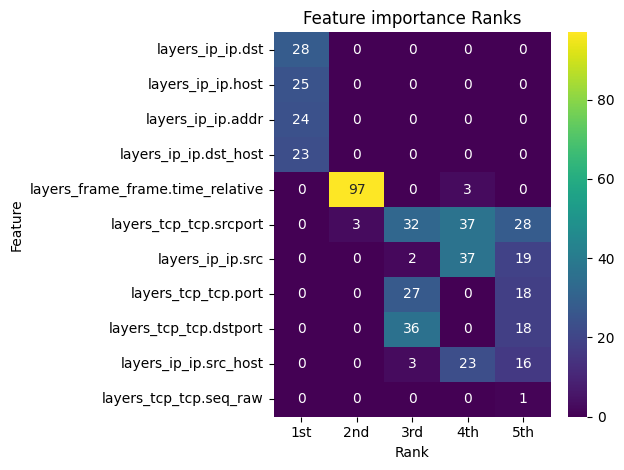

In [169]:
final_df = final_df.sort_values(by='1st', ascending=False)

sns.heatmap(final_df.drop(columns=['feature']), yticklabels=final_df['feature'], annot=True, cmap="viridis", fmt="d")
plt.title("Feature importance Ranks")
plt.ylabel("Feature")
plt.xlabel("Rank")
plt.tight_layout()
plt.show()

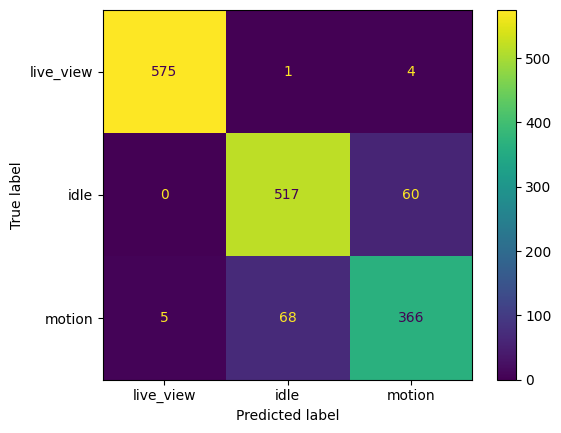

In [170]:
# confusion matrix for the last run
confuse = metrics.confusion_matrix(y_test, y_hat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confuse, display_labels = ['live_view', 'idle', 'motion'])
cm_display.plot()
plt.show()

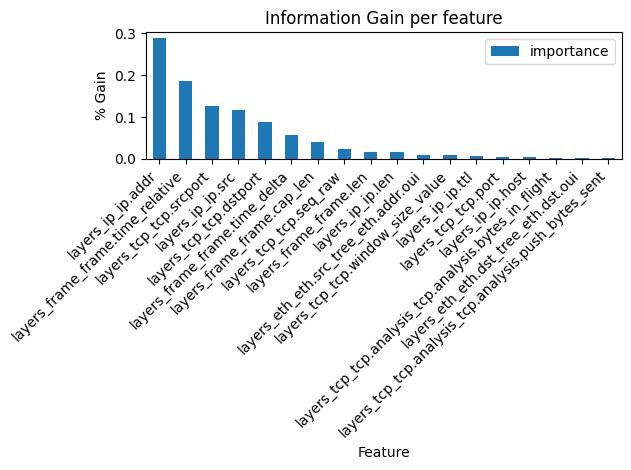

In [171]:
# visualzation of the imprtance
query = feature_importance_df.query('importance <= 0.001')
feature_importance_df = feature_importance_df[feature_importance_df['importance'] > 0.001]
ax = feature_importance_df.plot(kind='bar')
ax.set_xticklabels(feature_importance_df['feature'])
plt.xticks(rotation=45, ha='right') 
plt.title('Information Gain per feature')
plt.xlabel('Feature')
plt.ylabel('% Gain')
plt.tight_layout()
plt.show()